## Import modules

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchmetrics import Accuracy
from PIL import Image
import matplotlib.pyplot as plt

## Transform data

In [2]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

## Download train/test data

In [3]:
train_data = datasets.MNIST(root='data',
                            train=True,
                            transform=data_transform,
                            download=True)

test_data = datasets.MNIST(root='data',
                            train=False,
                            transform=data_transform,
                            download=True)

In [4]:
train_data[0][0].shape

torch.Size([3, 64, 64])

## Create dataloader

In [5]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=50,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=50,
                             shuffle=True)

## Build model

In [6]:
class DigitRecognitionModel(nn.Module):
    def __init__(self,
                 in_channel :int,
                 hidden_channel :int,
                 out_channel :int):
        super().__init__()

        self.conv_stack_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel,
                      out_channels=hidden_channel,
                      kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )

        self.conv_stack_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channel,
                      out_channels=hidden_channel,
                      kernel_size=5),
            nn.Dropout2d(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )

        self.linear_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_channel*900,
                      out_features=out_channel)
        )

    def forward(self, X :torch.Tensor):
        #print(X.shape)
        X = self.conv_stack_1(X)
        #print(X.shape)
        #X = self.conv_stack_2(X)
        #print(X.shape)
        X = self.linear_classifier(X)
        #print(X.shape)
        return X

In [7]:
model = DigitRecognitionModel(in_channel=3,
                              hidden_channel=10,
                              out_channel=len(train_data.classes))

In [8]:
X, y = next(iter(train_dataloader))
model(X[0].unsqueeze(dim=0))

tensor([[ 0.0743,  0.0070, -0.0759, -0.0683,  0.0862,  0.0870,  0.0959, -0.0669,
          0.2236, -0.1611]], grad_fn=<AddmmBackward0>)

## Train model

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr = 0.01)
acc_fn = Accuracy(task='multiclass',
                     num_classes = 10)

In [47]:
torch.manual_seed(42)
epoch_values = []
train_loss_values = []
test_loss_values = []
epochs = 30

for epoch in range(epochs):
    train_loss = 0
    train_acc = 0
    model.train()
    for X,y in train_dataloader:
        train_logit = model(X)
        train_loss += loss_fn(train_logit, y)
        train_pred = train_logit.argmax(dim=1)
        train_acc += acc_fn(train_pred, y)
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    model.eval()
    with torch.inference_mode():
        test_loss = 0
        test_acc = 0
        for X, y in test_dataloader:
            test_logit = model(X)
            test_loss += loss_fn(test_logit, y)
            test_pred = test_logit.argmax(dim=1)
            test_acc += acc_fn(test_pred, y)
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    if epoch%2==0:
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)
        print(f"Epoch : {epoch} | Train_loss : {train_loss :.3f} | Train_acc : {train_acc :.2f}% | Test_loss : {test_loss :.3f} | Test_acc : {test_acc :.2f}%")


        

Epoch : 0 | Train_loss : 0.137 | Train_acc : 0.96% | Test_loss : 0.148 | Test_acc : 0.96%
Epoch : 2 | Train_loss : 0.135 | Train_acc : 0.96% | Test_loss : 0.147 | Test_acc : 0.96%
Epoch : 4 | Train_loss : 0.133 | Train_acc : 0.96% | Test_loss : 0.146 | Test_acc : 0.96%
Epoch : 6 | Train_loss : 0.131 | Train_acc : 0.96% | Test_loss : 0.144 | Test_acc : 0.96%
Epoch : 8 | Train_loss : 0.129 | Train_acc : 0.96% | Test_loss : 0.143 | Test_acc : 0.96%
Epoch : 10 | Train_loss : 0.128 | Train_acc : 0.96% | Test_loss : 0.142 | Test_acc : 0.96%
Epoch : 12 | Train_loss : 0.126 | Train_acc : 0.96% | Test_loss : 0.141 | Test_acc : 0.96%
Epoch : 14 | Train_loss : 0.125 | Train_acc : 0.96% | Test_loss : 0.140 | Test_acc : 0.96%
Epoch : 16 | Train_loss : 0.123 | Train_acc : 0.96% | Test_loss : 0.139 | Test_acc : 0.96%
Epoch : 18 | Train_loss : 0.122 | Train_acc : 0.96% | Test_loss : 0.138 | Test_acc : 0.96%
Epoch : 20 | Train_loss : 0.120 | Train_acc : 0.97% | Test_loss : 0.137 | Test_acc : 0.96%
Epoc

## Make predictions

In [65]:
class MakePrediction():
    def __init__(self,
                 path :str):
        self.path = path
        self.img = Image.open(self.path)
        self.img = transforms.functional.invert(self.img)
        self.tensor = data_transform(self.img)

    def show_image(self):
        return self.img
    
    def show_prediction(self):
        digit = model(self.tensor.unsqueeze(dim=0))
        prediction = digit.argmax(dim=1)
        return prediction
    
    def plot_img(self):
        plt.imshow(self.tensor.permute(1,2,0), cmap='gray')

3


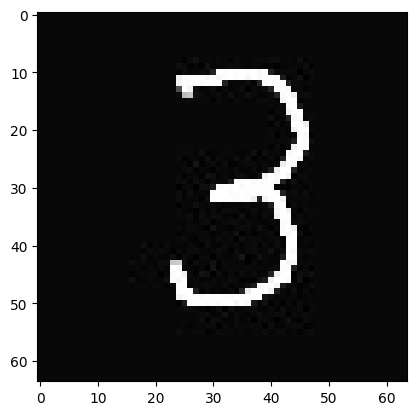

In [91]:
a = MakePrediction('/Users/navalmor/Desktop/Image Recognition/three.JPG')
a.plot_img()
print(a.show_prediction().item())

## Save/Load model

In [79]:
torch.save(obj=model.state_dict(), f='/Users/navalmor/Desktop/Image Recognition/model/DigitRecognitionModelParameter.pt')
torch.save(obj=model, f='/Users/navalmor/Desktop/Image Recognition/model/DigitRecognitionModel.pt')

In [69]:
loaded_model = torch.load(f='/Users/navalmor/Desktop/Image Recognition/model/DigitRecognitionModel.pt')

In [77]:
loaded_model.eval()
img = Image.open('/Users/navalmor/Desktop/Image Recognition/0 1 2.jpeg')
tr_img = data_transform(img)
loaded_model(tr_img.unsqueeze(0)).argmax(1)

tensor([0])

In [81]:
model_scripted = torch.jit.script(model)
model_scripted.save('scripted_model.pt')